<h1>Handwriting Letter GAN</h1>

<h3>Links</h3>
<ul>
    <li><a href=https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/>cGAN Code</a></li>
    <li><a href=https://keras.io/getting-started/functional-api-guide/>Keras Functional API</a></li>
</ul>

In [1]:
import numpy as np
from numpy.random import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from emnist import *
from skimage import data, io, transform
import matplotlib.pyplot as plt

tf.test.gpu_device_name()

''

In [2]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

(112800, 28, 28) (112800,)
33
(2400, 28, 28) (2400,)


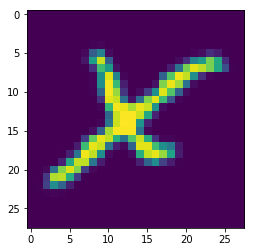

In [3]:
images, labels = extract_training_samples('balanced')
print(images.shape, labels.shape)
plt.imshow(images[908])
print(labels[908])
ind = np.where(labels==8)
images, labels = images[ind], labels[ind]
print(images.shape, labels.shape)

In [4]:
def define_discriminator(input_shape=(28, 28, 1), n_classes=47):
    # label input and embedding
    label_in = Input(shape=(1, ))
    emb = Embedding(n_classes, 50)(label_in)
    label_h = Dense(input_shape[0] * input_shape[1])(emb)
    re_label_h = Reshape((input_shape[0], input_shape[1], 1))(label_h)
    # image input
    image_in = Input(shape=input_shape)
    # combine inputs
    merge = Concatenate()([image_in, re_label_h])
    # convnet
    h1 = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(merge)
    r1 = LeakyReLU(alpha=0.2)(h1)
    h2 = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(r1)
    r2 = LeakyReLU(alpha=0.2)(h2)
    # fully connected net
    fl = Flatten()(r2)
    dr = Dropout(0.4)(fl)
    # output
    out = Dense(1, activation='sigmoid')(dr)
    # define and compile model
    model = Model([image_in, label_in], out)
    opt = Adam(lr=2e-4, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [5]:
def define_generator(latent_dim, n_classes=47):
    # label input and embedding
    label_in = Input(shape=(1, ))
    emb = Embedding(n_classes, 50)(label_in)
    label_h = Dense(7*7)(emb)
    re_label_h = Reshape((7, 7, 1))(label_h)
    # noisy image input
    noise_in = Input(shape=(latent_dim,))
    noise_h = Dense(128*7*7)(noise_in)
    noise_r = LeakyReLU(alpha=0.2)(noise_h)
    re_noise_r = Reshape((7, 7, 128))(noise_r)
    # combine inputs
    merge = Concatenate()([re_noise_r, re_label_h])
    # upsampling
    u1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)
    r1 = LeakyReLU(alpha=0.2)(u1)
    u2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(r1)
    r2 = LeakyReLU(alpha=0.2)(u2)
    # output
    out = Conv2D(1, (7, 7), activation='tanh', padding='same')(r2)
    # define model
    model = Model([noise_in, label_in], out)
    return model

In [6]:
def define_gan(gen, dis):
    # discriminator shouldn't be trainable
    dis.trainable = False
    # get generator inputs and outputs
    gen_noise, gen_label = gen.input
    gen_output = gen.output
    # feed to discriminator
    gan_output = dis([gen_output, gen_label])
    # define and compile GAN model
    model = Model([gen_noise, gen_label], gan_output)
    opt = Adam(lr=2e-4, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [7]:
def prepare_inputs(images, labels):
    X = np.expand_dims(images, axis=-1)
    X = X.astype('float32')
    X = (X-127.5) / 127.5
    return [X, labels]
    
def generate_real_samples(images, labels, n_samples):
    rand_index = randint(0, images.shape[0], n_samples)
    X, labels = images[rand_index], labels[rand_index]
    y = np.ones((n_samples, 1))  # discriminator target label
    return [X, labels], y

def generate_latent_noise(latent_dim, n_samples, n_classes=47):
    xin = randn(latent_dim * n_samples)
    xin = xin.reshape(n_samples, latent_dim)
    labels = randint(0, n_classes, n_samples)  #  generator class label
    return xin, labels

def generate_fake_samples(gen, latent_dim, n_samples):
    zin, lin = generate_latent_noise(latent_dim, n_samples)
    images = gen.predict([zin, lin])
    y = np.zeros((n_samples, 1))  # discriminator target label
    return [images, lin], y

In [8]:
def train_gan(gen, dis, gan_model, images, labels, latent_dim, n_epochs=100, batch_size=128):
    batch_per_epoch = int(images.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # enumerate epochs
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            # train discriminator on real images
            [X_real, labels_real], y_real = generate_real_samples(images, labels, half_batch)
            d_loss1, _ = dis.train_on_batch([X_real, labels_real], y_real)
            # train discriminator on generated images
            [X_fake, labels_fake], y_fake = generate_fake_samples(gen, latent_dim, half_batch)
            d_loss2, _ = dis.train_on_batch([X_fake, labels_fake], y_fake)
            # prepare generator input
            [zin, label_in] = generate_latent_noise(latent_dim, batch_size)
            # invert labels for fake samples (prevent vanishing gradients)
            y_gan = np.ones((batch_size, 1))
            # update generator loss
            g_loss = gan_model.train_on_batch([zin, label_in], y_gan)
            # output losses
            print('Epoch {}, batch {}/{}:\tDiscriminator: real loss {}, fake loss {}\tGenerator: loss {}'
                  .format(i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
    # save the models
    gen.save('generator.h5')
    dis.save('discriminator.h5')
    gan_model.save('gan.h5')    

In [9]:
latent_dim = 100
images, labels = prepare_inputs(images, labels)
print(images.shape, labels.shape)
dis = define_discriminator()
gen = define_generator(latent_dim)
gan_model = define_gan(gen, dis)

(2400, 28, 28, 1) (2400,)


In [10]:
print("\nDiscriminator\n")
dis.summary()
print("\nGenerator\n")
gen.summary()
print("\nGAN\n")
gan_model.summary()

W0414 16:37:12.048755 140542877202240 training.py:2031] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?



Discriminator

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        2350        input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 784)       39984       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________

In [11]:
print(images.shape, labels.shape)
train_gan(gen, dis, gan_model, images, labels, latent_dim, n_epochs=20, batch_size=100)

(2400, 28, 28, 1) (2400,)
Epoch 1, batch 1/24:	Discriminator: real loss 0.6636178493499756, fake loss 0.6947387456893921	Generator: loss 0.6921485662460327
Epoch 1, batch 2/24:	Discriminator: real loss 0.5767524242401123, fake loss 0.6997467875480652	Generator: loss 0.6865689158439636
Epoch 1, batch 3/24:	Discriminator: real loss 0.5017088055610657, fake loss 0.7113028168678284	Generator: loss 0.6767809391021729
Epoch 1, batch 4/24:	Discriminator: real loss 0.4341706335544586, fake loss 0.7283117771148682	Generator: loss 0.6606583595275879
Epoch 1, batch 5/24:	Discriminator: real loss 0.37184181809425354, fake loss 0.7525793313980103	Generator: loss 0.6413789391517639
Epoch 1, batch 6/24:	Discriminator: real loss 0.3319576382637024, fake loss 0.786135733127594	Generator: loss 0.6179372668266296
Epoch 1, batch 7/24:	Discriminator: real loss 0.28690582513809204, fake loss 0.8222193717956543	Generator: loss 0.5979483723640442
Epoch 1, batch 8/24:	Discriminator: real loss 0.256593137979507

Epoch 3, batch 16/24:	Discriminator: real loss 0.2755134701728821, fake loss 0.35561755299568176	Generator: loss 1.594071865081787
Epoch 3, batch 17/24:	Discriminator: real loss 0.1678934544324875, fake loss 0.43603143095970154	Generator: loss 1.8302656412124634
Epoch 3, batch 18/24:	Discriminator: real loss 0.20931264758110046, fake loss 0.2694966793060303	Generator: loss 1.9331905841827393
Epoch 3, batch 19/24:	Discriminator: real loss 0.21485507488250732, fake loss 0.31179776787757874	Generator: loss 2.0043747425079346
Epoch 3, batch 20/24:	Discriminator: real loss 0.20741505920886993, fake loss 0.33283600211143494	Generator: loss 2.286572217941284
Epoch 3, batch 21/24:	Discriminator: real loss 0.1605815291404724, fake loss 0.1606629192829132	Generator: loss 2.3478031158447266
Epoch 3, batch 22/24:	Discriminator: real loss 0.15159454941749573, fake loss 0.17239080369472504	Generator: loss 2.51698637008667
Epoch 3, batch 23/24:	Discriminator: real loss 0.09976468235254288, fake loss 

Epoch 6, batch 7/24:	Discriminator: real loss 0.013961701653897762, fake loss 0.18030859529972076	Generator: loss 5.889367580413818
Epoch 6, batch 8/24:	Discriminator: real loss 0.014945775270462036, fake loss 0.17448827624320984	Generator: loss 6.053382396697998
Epoch 6, batch 9/24:	Discriminator: real loss 0.018282411620020866, fake loss 0.13774627447128296	Generator: loss 6.181058406829834
Epoch 6, batch 10/24:	Discriminator: real loss 0.025739751756191254, fake loss 0.002071749186143279	Generator: loss 6.1779656410217285
Epoch 6, batch 11/24:	Discriminator: real loss 0.02478298917412758, fake loss 0.07165823131799698	Generator: loss 6.114774227142334
Epoch 6, batch 12/24:	Discriminator: real loss 0.023402519524097443, fake loss 0.08513485640287399	Generator: loss 5.965953350067139
Epoch 6, batch 13/24:	Discriminator: real loss 0.020165178924798965, fake loss 0.16309157013893127	Generator: loss 6.149351119995117
Epoch 6, batch 14/24:	Discriminator: real loss 0.025001242756843567, fa

Epoch 8, batch 21/24:	Discriminator: real loss 0.017290497198700905, fake loss 0.18058598041534424	Generator: loss 6.975350856781006
Epoch 8, batch 22/24:	Discriminator: real loss 0.016952121630311012, fake loss 0.06504040211439133	Generator: loss 7.114556789398193
Epoch 8, batch 23/24:	Discriminator: real loss 0.019498832523822784, fake loss 0.0821208730340004	Generator: loss 6.974124908447266
Epoch 8, batch 24/24:	Discriminator: real loss 0.016425536945462227, fake loss 0.06406031548976898	Generator: loss 7.019957065582275
Epoch 9, batch 1/24:	Discriminator: real loss 0.019097935408353806, fake loss 0.2689049243927002	Generator: loss 7.479466438293457
Epoch 9, batch 2/24:	Discriminator: real loss 0.027955874800682068, fake loss 0.00063188566127792	Generator: loss 7.2435407638549805
Epoch 9, batch 3/24:	Discriminator: real loss 0.030531523749232292, fake loss 0.07054968923330307	Generator: loss 7.075603008270264
Epoch 9, batch 4/24:	Discriminator: real loss 0.016300931572914124, fake 

Epoch 11, batch 11/24:	Discriminator: real loss 0.02853200025856495, fake loss 0.062143124639987946	Generator: loss 7.463047027587891
Epoch 11, batch 12/24:	Discriminator: real loss 0.020575370639562607, fake loss 0.07392046600580215	Generator: loss 7.485661506652832
Epoch 11, batch 13/24:	Discriminator: real loss 0.01800238899886608, fake loss 0.13119369745254517	Generator: loss 7.615156173706055
Epoch 11, batch 14/24:	Discriminator: real loss 0.02581658586859703, fake loss 0.0005687081138603389	Generator: loss 7.304605484008789
Epoch 11, batch 15/24:	Discriminator: real loss 0.018215112388134003, fake loss 0.0005590546643361449	Generator: loss 7.214487075805664
Epoch 11, batch 16/24:	Discriminator: real loss 0.01316817756742239, fake loss 0.0007870064582675695	Generator: loss 7.3270416259765625
Epoch 11, batch 17/24:	Discriminator: real loss 0.013215824030339718, fake loss 0.08994787186384201	Generator: loss 7.178089141845703
Epoch 11, batch 18/24:	Discriminator: real loss 0.01159111

Epoch 14, batch 1/24:	Discriminator: real loss 0.018940124660730362, fake loss 0.09954448789358139	Generator: loss 7.5484538078308105
Epoch 14, batch 2/24:	Discriminator: real loss 0.015409142710268497, fake loss 0.26701006293296814	Generator: loss 7.763952732086182
Epoch 14, batch 3/24:	Discriminator: real loss 0.02479124255478382, fake loss 0.0724884644150734	Generator: loss 8.011752128601074
Epoch 14, batch 4/24:	Discriminator: real loss 0.031314507126808167, fake loss 0.0003576980088837445	Generator: loss 7.7583231925964355
Epoch 14, batch 5/24:	Discriminator: real loss 0.02310040406882763, fake loss 0.00047145254211500287	Generator: loss 7.233945369720459
Epoch 14, batch 6/24:	Discriminator: real loss 0.01728242263197899, fake loss 0.000549863965716213	Generator: loss 7.369713306427002
Epoch 14, batch 7/24:	Discriminator: real loss 0.01296915765851736, fake loss 0.000705895246937871	Generator: loss 7.124973773956299
Epoch 14, batch 8/24:	Discriminator: real loss 0.0081489048898220

Epoch 16, batch 15/24:	Discriminator: real loss 0.021723976358771324, fake loss 0.07255499809980392	Generator: loss 8.643248558044434
Epoch 16, batch 16/24:	Discriminator: real loss 0.03182336315512657, fake loss 0.0002536250976845622	Generator: loss 8.050095558166504
Epoch 16, batch 17/24:	Discriminator: real loss 0.02306196838617325, fake loss 0.1744871288537979	Generator: loss 7.955628871917725
Epoch 16, batch 18/24:	Discriminator: real loss 0.02902337722480297, fake loss 0.10457482933998108	Generator: loss 8.095495223999023
Epoch 16, batch 19/24:	Discriminator: real loss 0.03197852894663811, fake loss 0.00033080787397921085	Generator: loss 8.183526992797852
Epoch 16, batch 20/24:	Discriminator: real loss 0.024848468601703644, fake loss 0.00034062727354466915	Generator: loss 8.06337833404541
Epoch 16, batch 21/24:	Discriminator: real loss 0.014681215398013592, fake loss 0.05621201545000076	Generator: loss 7.581722259521484
Epoch 16, batch 22/24:	Discriminator: real loss 0.0141749558

Epoch 19, batch 5/24:	Discriminator: real loss 0.02803250588476658, fake loss 0.15392696857452393	Generator: loss 8.805416107177734
Epoch 19, batch 6/24:	Discriminator: real loss 0.04795742407441139, fake loss 0.12029403448104858	Generator: loss 8.820765495300293
Epoch 19, batch 7/24:	Discriminator: real loss 0.04619792848825455, fake loss 0.05251866951584816	Generator: loss 8.479482650756836
Epoch 19, batch 8/24:	Discriminator: real loss 0.03440472483634949, fake loss 0.13367226719856262	Generator: loss 8.459129333496094
Epoch 19, batch 9/24:	Discriminator: real loss 0.03402867168188095, fake loss 0.12712125480175018	Generator: loss 8.365797996520996
Epoch 19, batch 10/24:	Discriminator: real loss 0.033821046352386475, fake loss 0.0002394819020992145	Generator: loss 7.984453201293945
Epoch 19, batch 11/24:	Discriminator: real loss 0.02531379461288452, fake loss 0.36442142724990845	Generator: loss 8.352097511291504
Epoch 19, batch 12/24:	Discriminator: real loss 0.03580927476286888, fa

W0414 16:51:22.860143 140542877202240 hdf5_format.py:177] No training configuration found in save file: the model was *not* compiled. Compile it manually.


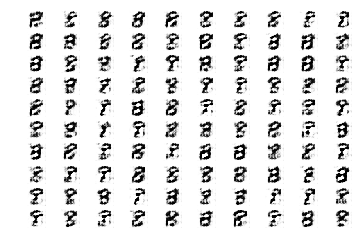

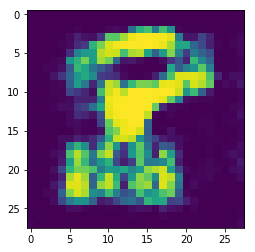

In [12]:
def show_plot(examples, n):
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(examples[i,:,:,0], cmap='gray_r')
    plt.show()

model = load_model('generator.h5')
noise, _ = generate_latent_noise(100, 100)
labels = np.asarray([x for _ in range(10) for x in range(10)])
X = model.predict([noise, labels])
# scale from [-1, 1] to [0, 1]
X = (X + 1) / 2.0
show_plot(X, 10)
X[0].shape
for i in range(90):
    x = np.squeeze(X[i])
    plt.imshow(x)